# Comprehensive Feature Selection Guide for Statistical Machine Learning

## A Mathematical Perspective for Graduate Studies in ML and Neural Networks

**Author's Note:** This notebook provides a rigorous mathematical treatment of feature selection techniques essential for courses in Statistical Machine Learning and Neural Networks. Each method is presented with formal definitions, mathematical derivations, and practical implementations.

---

## Table of Contents

1. [Introduction and Motivation](#introduction)
2. [Mathematical Foundations](#foundations)
3. [Filter Methods](#filter-methods)
   - Variance Threshold
   - Correlation-Based Selection
   - Statistical Tests (χ², ANOVA F-test, Mutual Information)
4. [Wrapper Methods](#wrapper-methods)
   - Recursive Feature Elimination (RFE)
   - Forward/Backward Selection
5. [Embedded Methods](#embedded-methods)
   - L1 Regularization (Lasso)
   - L2 Regularization (Ridge)
   - Elastic Net
   - Tree-Based Feature Importance
6. [Dimensionality Reduction](#dimensionality-reduction)
   - Principal Component Analysis (PCA)
   - Mathematical Derivation of PCA
7. [Advanced Topics](#advanced-topics)
   - Bias-Variance Tradeoff in Feature Selection
   - Information Theory Perspective
8. [Practical Guidelines and Comparative Analysis](#guidelines)
9. [Complete Examples](#examples)

In [2]:
# Essential imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.linalg import eigh

# Scikit-learn imports
from sklearn.datasets import load_breast_cancer, fetch_covtype, load_diabetes
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import (
    VarianceThreshold, SelectKBest, f_classif, chi2, mutual_info_classif,
    mutual_info_regression, RFE, SelectFromModel
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

# Set display options
np.set_printoptions(precision=4, suppress=True)
pd.set_option('display.precision', 4)
plt.style.use('seaborn-v0_8-darkgrid')

print("Libraries imported successfully")

Libraries imported successfully


---

## 1. Introduction and Motivation <a id="introduction"></a>

### 1.1 The Curse of Dimensionality

**Definition (High-Dimensional Space):** Let $\mathcal{X} \subseteq \mathbb{R}^p$ be our feature space where $p$ is the number of features. As $p$ increases:

1. **Volume Concentration:** For a unit hypercube $[0,1]^p$, the ratio of the volume of a hypersphere inscribed in the cube to the volume of the cube is:
   $$\frac{V_{\text{sphere}}}{V_{\text{cube}}} = \frac{\pi^{p/2}}{2^p \Gamma(p/2 + 1)} \to 0 \text{ as } p \to \infty$$

2. **Distance Concentration:** For i.i.d. random variables $X_1, \ldots, X_p \sim \mathcal{N}(0,1)$, the ratio of maximum to minimum pairwise distances concentrates around 1:
   $$\frac{\max_{i,j} \|X_i - X_j\|}{\min_{i,j} \|X_i - X_j\|} \xrightarrow{p} 1$$

3. **Sample Complexity:** To maintain the same predictive accuracy, the required sample size grows exponentially with dimension $p$.

### 1.2 Why Feature Selection?

**Objectives:**
- **Improved Generalization:** Reduce overfitting by limiting model complexity
- **Computational Efficiency:** Decrease training and inference time
- **Interpretability:** Understand which features drive predictions
- **Statistical Power:** Reduce noise and improve signal-to-noise ratio

**Formal Problem Statement:**

Given:
- Dataset $\mathcal{D} = \{(\mathbf{x}_i, y_i)\}_{i=1}^n$ where $\mathbf{x}_i \in \mathbb{R}^p$, $y_i \in \mathcal{Y}$
- Loss function $\ell: \mathcal{Y} \times \mathcal{Y} \to \mathbb{R}_+$
- Model class $\mathcal{H}$

Find: Subset $S \subseteq \{1, \ldots, p\}$ with $|S| = k < p$ such that
$$S^* = \arg\min_{S: |S|=k} \mathbb{E}_{(\mathbf{x},y) \sim P} \left[ \min_{h \in \mathcal{H}} \ell(h(\mathbf{x}_S), y) \right]$$
where $\mathbf{x}_S$ denotes the feature vector restricted to indices in $S$.

---

## 2. Mathematical Foundations <a id="foundations"></a>

### 2.1 Taxonomy of Feature Selection Methods

**Filter Methods:** Independent of learning algorithm, use statistical properties
$$\text{Score}(X_j) = f(X_j, y) \quad \text{(univariate)}$$
or
$$\text{Score}(S) = f(\mathbf{X}_S, y) \quad \text{(multivariate)}$$

**Wrapper Methods:** Use predictive model as black box
$$S^* = \arg\min_{S} \text{CV-Error}(\text{Model}_S)$$

**Embedded Methods:** Feature selection as part of model training
$$\min_{\mathbf{w}} \left[ \mathcal{L}(\mathbf{w}) + \lambda \|\mathbf{w}\|_p \right]$$
where $p \in \{0, 1, 2\}$ determines sparsity pattern.

### 2.2 Information-Theoretic Measures

**Shannon Entropy:**
$$H(X) = -\sum_{x} p(x) \log p(x) = \mathbb{E}[-\log p(X)]$$

**Mutual Information:**
$$I(X; Y) = H(Y) - H(Y|X) = \sum_{x,y} p(x,y) \log \frac{p(x,y)}{p(x)p(y)}$$

**Properties:**
1. $I(X; Y) \geq 0$ with equality iff $X \perp Y$
2. $I(X; Y) = I(Y; X)$ (symmetry)
3. $I(X; Y) \leq \min\{H(X), H(Y)\}$

**Conditional Mutual Information:**
$$I(X; Y | Z) = H(Y|Z) - H(Y|X,Z)$$

This measures redundancy: if $I(X_i; Y | X_j)$ is small, then $X_i$ is redundant given $X_j$.

---

## 3. Filter Methods <a id="filter-methods"></a>

### 3.1 Variance Threshold

**Motivation:** Features with low variance provide little discriminative information.

**Definition:** For feature $X_j$, the sample variance is:
$$\hat{\sigma}_j^2 = \frac{1}{n-1} \sum_{i=1}^n (x_{ij} - \bar{x}_j)^2$$

**Selection Rule:** Remove features where $\hat{\sigma}_j^2 < \tau$ for threshold $\tau \geq 0$.

**Special Case (Binary Features):** For Bernoulli random variable $X \sim \text{Ber}(p)$:
$$\text{Var}(X) = p(1-p)$$

This is maximized at $p = 0.5$ and approaches 0 as $p \to \{0, 1\}$.

**Limitations:**
- Univariate: ignores feature interactions
- Variance depends on scale (require normalization)
- No consideration of relationship with target $y$

In [3]:
# Load a high-dimensional dataset
print("Loading Forest Covertype dataset...")
X, y = fetch_covtype(return_X_y=True, as_frame=True)
print(f"Dataset shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"\nFirst few rows:")
print(X.head())

Loading Forest Covertype dataset...
Dataset shape: (581012, 54)
Number of features: 54
Number of samples: 581012

First few rows:
   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0     2596.0    51.0    3.0                             258.0   
1     2590.0    56.0    2.0                             212.0   
2     2804.0   139.0    9.0                             268.0   
3     2785.0   155.0   18.0                             242.0   
4     2595.0    45.0    2.0                             153.0   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                             0.0                            510.0   
1                            -6.0                            390.0   
2                            65.0                           3180.0   
3                           118.0                           3090.0   
4                            -1.0                            391.0   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0      

In [4]:
# Variance Threshold Example
from sklearn.feature_selection import VarianceThreshold

# Compute variances
variances = X.var(axis=0)
print(f"Variance statistics:")
print(f"Mean: {variances.mean():.4f}")
print(f"Std: {variances.std():.4f}")
print(f"Min: {variances.min():.4f}")
print(f"Max: {variances.max():.4f}")

# Apply variance threshold
thresholds = [0.0, 0.1, 1.0, 10.0]
for threshold in thresholds:
    selector = VarianceThreshold(threshold=threshold)
    X_selected = selector.fit_transform(X)
    print(f"\nThreshold = {threshold}:")
    print(f"  Features retained: {X_selected.shape[1]} / {X.shape[1]}")
    print(f"  Reduction: {100 * (1 - X_selected.shape[1]/X.shape[1]):.1f}%")

Variance statistics:
Mean: 80127.5992
Std: 403931.0002
Min: 0.0000
Max: 2431275.7493

Threshold = 0.0:
  Features retained: 54 / 54
  Reduction: 0.0%

Threshold = 0.1:
  Features retained: 13 / 54
  Reduction: 75.9%

Threshold = 1.0:
  Features retained: 10 / 54
  Reduction: 81.5%

Threshold = 10.0:
  Features retained: 10 / 54
  Reduction: 81.5%


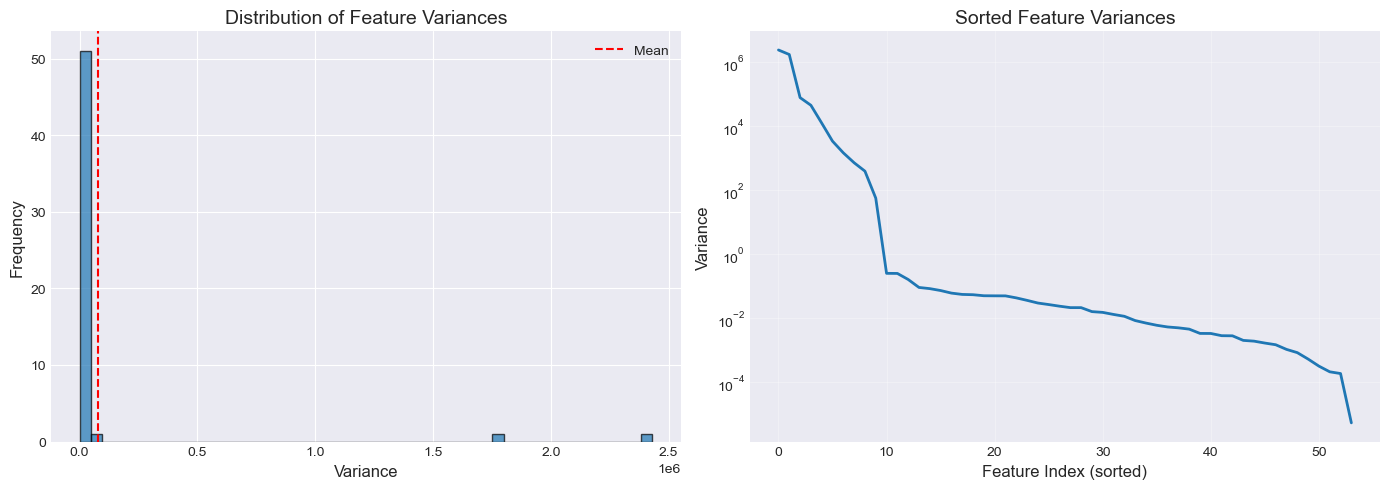

In [5]:
# Visualize variance distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of variances
axes[0].hist(variances, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Variance', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Feature Variances', fontsize=14)
axes[0].axvline(variances.mean(), color='red', linestyle='--', label='Mean')
axes[0].legend()

# Features vs variance
sorted_vars = np.sort(variances)[::-1]
axes[1].plot(range(len(sorted_vars)), sorted_vars, linewidth=2)
axes[1].set_xlabel('Feature Index (sorted)', fontsize=12)
axes[1].set_ylabel('Variance', fontsize=12)
axes[1].set_title('Sorted Feature Variances', fontsize=14)
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.2 Correlation-Based Selection

**Pearson Correlation Coefficient:**
$$\rho(X, Y) = \frac{\text{Cov}(X, Y)}{\sigma_X \sigma_Y} = \frac{\mathbb{E}[(X - \mu_X)(Y - \mu_Y)]}{\sigma_X \sigma_Y}$$

**Sample Estimator:**
$$\hat{\rho}(X, Y) = \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^n (x_i - \bar{x})^2} \sqrt{\sum_{i=1}^n (y_i - \bar{y})^2}}$$

**Properties:**
1. $-1 \leq \rho(X,Y) \leq 1$
2. $|\rho(X,Y)| = 1$ iff $Y = aX + b$ for some $a, b \in \mathbb{R}$
3. $\rho(X,Y) = 0$ does NOT imply independence (only detects linear relationships)

**Statistical Test:**
Under $H_0: \rho = 0$, the test statistic
$$t = \frac{\hat{\rho}\sqrt{n-2}}{\sqrt{1 - \hat{\rho}^2}} \sim t_{n-2}$$

**Selection Strategy:**
1. Compute $|\rho(X_j, y)|$ for each feature $j$
2. Rank features by correlation magnitude
3. Select top $k$ features or apply threshold

**Limitations:**
- Only captures linear relationships
- Sensitive to outliers
- Ignores feature redundancy

C:\Users\Socrates\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Socrates\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Top 10 features by absolute correlation with target:
Wilderness_Area_3                  0.3280
Elevation                          0.2787
Soil_Type_9                        0.2399
Soil_Type_37                       0.2038
Wilderness_Area_0                  0.2008
Soil_Type_38                       0.1663
Horizontal_Distance_To_Roadways    0.1514
Slope                              0.1476
Soil_Type_21                       0.1430
Soil_Type_22                       0.1288
dtype: float64


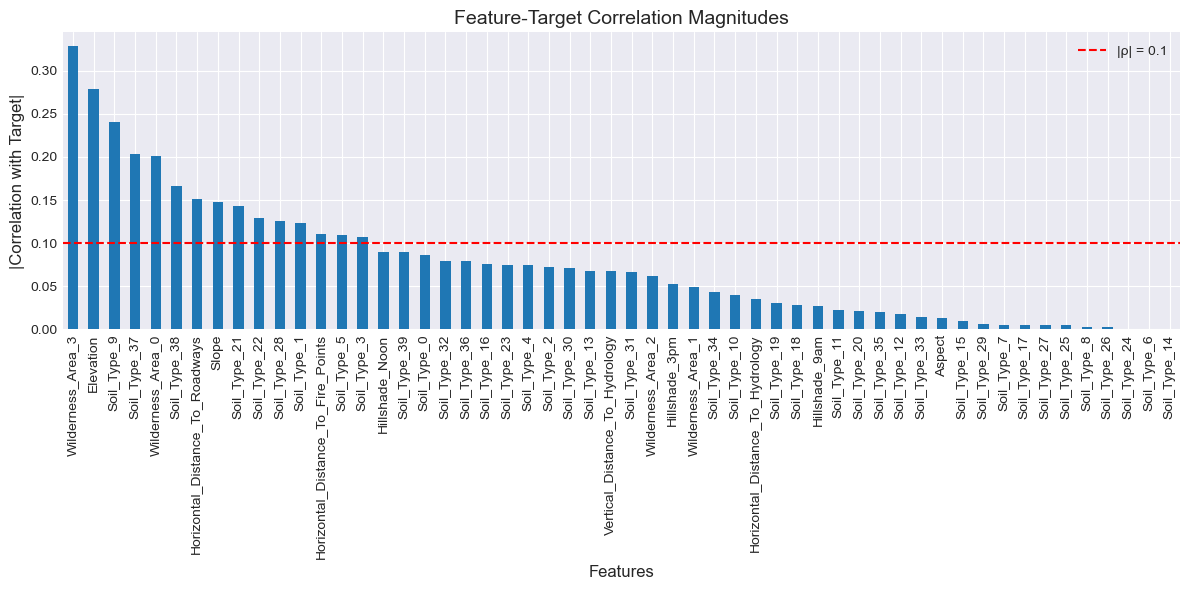

In [6]:
# Correlation-based feature selection
# Sample a subset for computational efficiency
np.random.seed(42)
sample_indices = np.random.choice(len(X), size=10000, replace=False)
X_sample = X.iloc[sample_indices]
y_sample = y.iloc[sample_indices]

# Compute correlations with target
correlations = X_sample.corrwith(pd.Series(y_sample, index=X_sample.index))
abs_correlations = correlations.abs().sort_values(ascending=False)

print("Top 10 features by absolute correlation with target:")
print(abs_correlations.head(10))

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
abs_correlations.plot(kind='bar', ax=ax)
ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('|Correlation with Target|', fontsize=12)
ax.set_title('Feature-Target Correlation Magnitudes', fontsize=14)
ax.axhline(y=0.1, color='r', linestyle='--', label='|ρ| = 0.1')
ax.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

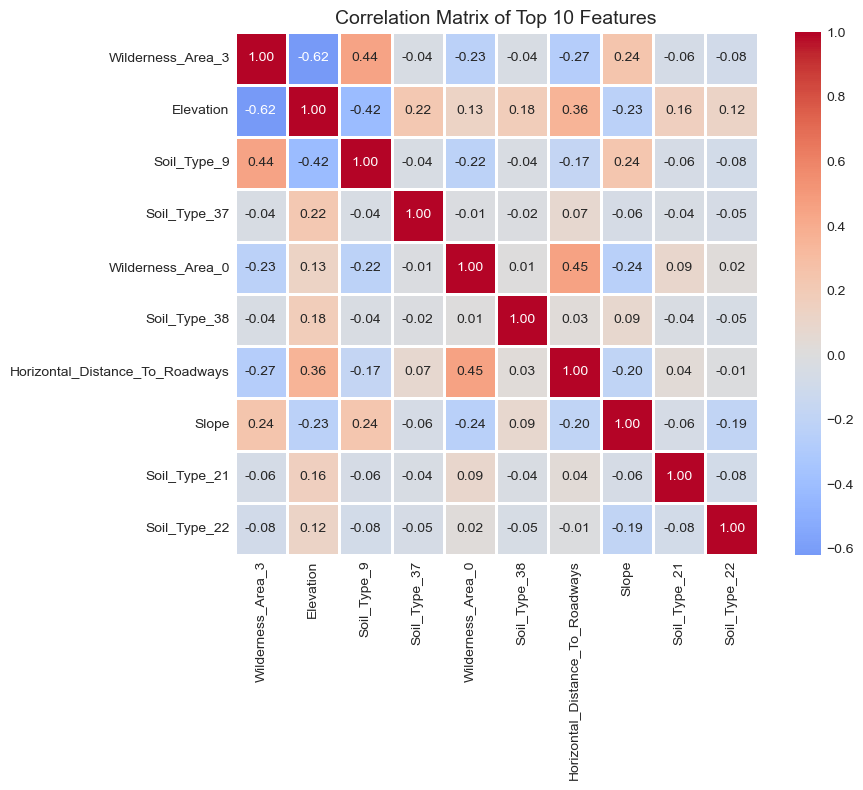


Note: High off-diagonal values indicate redundant features


In [7]:
# Feature-feature correlation (checking for redundancy)
top_features = abs_correlations.head(10).index.tolist()
corr_matrix = X_sample[top_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Correlation Matrix of Top 10 Features', fontsize=14)
plt.tight_layout()
plt.show()

print("\nNote: High off-diagonal values indicate redundant features")

### 3.3 Statistical Tests for Feature Selection

#### 3.3.1 ANOVA F-test (Classification)

**Setting:** $y \in \{1, \ldots, K\}$ (classification), $X_j \in \mathbb{R}$ (continuous feature)

**Hypothesis:**
- $H_0$: $\mathbb{E}[X_j | y=k]$ is the same for all classes $k$
- $H_1$: At least one class has different mean

**F-statistic:**
$$F = \frac{\text{Between-group variability}}{\text{Within-group variability}} = \frac{\sum_{k=1}^K n_k (\bar{x}_k - \bar{x})^2 / (K-1)}{\sum_{k=1}^K \sum_{i: y_i=k} (x_{ij} - \bar{x}_k)^2 / (n-K)}$$

where:
- $n_k = |\{i: y_i = k\}|$ (class size)
- $\bar{x}_k = \frac{1}{n_k} \sum_{i: y_i=k} x_{ij}$ (class mean)
- $\bar{x} = \frac{1}{n} \sum_{i=1}^n x_{ij}$ (overall mean)

Under $H_0$: $F \sim F_{K-1, n-K}$

**Intuition:** Large $F$ means feature values differ significantly across classes.

#### 3.3.2 Chi-Squared Test (χ²)

**Setting:** Both $X_j$ and $y$ are categorical

**Test Statistic:**
$$\chi^2 = \sum_{i=1}^r \sum_{j=1}^c \frac{(O_{ij} - E_{ij})^2}{E_{ij}}$$

where:
- $O_{ij}$ = observed frequency in cell $(i,j)$
- $E_{ij} = \frac{n_{i \cdot} n_{\cdot j}}{n}$ = expected frequency under independence

Under $H_0$ (independence): $\chi^2 \sim \chi^2_{(r-1)(c-1)}$

**Connection to Mutual Information:**
$$I(X; Y) \approx \frac{\chi^2}{2n} \quad \text{for large } n$$

#### 3.3.3 Mutual Information

**Discrete Case:**
$$I(X; Y) = \sum_{x \in \mathcal{X}} \sum_{y \in \mathcal{Y}} p(x,y) \log \frac{p(x,y)}{p(x)p(y)}$$

**Continuous Case (Differential Entropy):**
$$I(X; Y) = \int \int p(x,y) \log \frac{p(x,y)}{p(x)p(y)} dx dy$$

**Estimation Methods:**
1. **Histogram-based:** Discretize continuous variables
2. **KDE:** Use kernel density estimation
3. **k-NN:** $I(X;Y) \approx \psi(k) - \langle \psi(n_x) + \psi(n_y) \rangle + \psi(n)$

where $\psi$ is the digamma function and $n_x, n_y$ are k-nearest neighbor counts.

**Advantages over correlation:**
- Captures nonlinear relationships
- Invariant under monotonic transformations
- Well-defined for categorical variables

In [8]:
# Load breast cancer dataset for classification example
print("Loading Breast Cancer dataset...")
bc_data = load_breast_cancer()
X_bc = pd.DataFrame(bc_data['data'], columns=bc_data['feature_names'])
y_bc = bc_data['target']

print(f"Dataset shape: {X_bc.shape}")
print(f"Class distribution: {np.bincount(y_bc)}")
print(f"Feature names: {list(X_bc.columns[:5])} ...")

Loading Breast Cancer dataset...
Dataset shape: (569, 30)
Class distribution: [212 357]
Feature names: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness'] ...


Top 10 features by ANOVA F-test:
                 Feature  F-statistic      p-value  -log10(p)
27  worst concave points     964.3854  1.9691e-124   123.7057
22       worst perimeter     897.9442  5.7714e-119   118.2387
7    mean concave points     861.6760  7.1012e-116   115.1487
20          worst radius     860.7817  8.4823e-116   115.0715
2         mean perimeter     697.2353  8.4363e-101   100.0739
23            worst area     661.6002   2.8288e-97    96.5484
0            mean radius     646.9810   8.4659e-96    95.0723
3              mean area     573.0607   4.7346e-88    87.3247
6         mean concavity     533.7931   9.9666e-84    83.0015
26       worst concavity     436.6919   2.4647e-72    71.6082


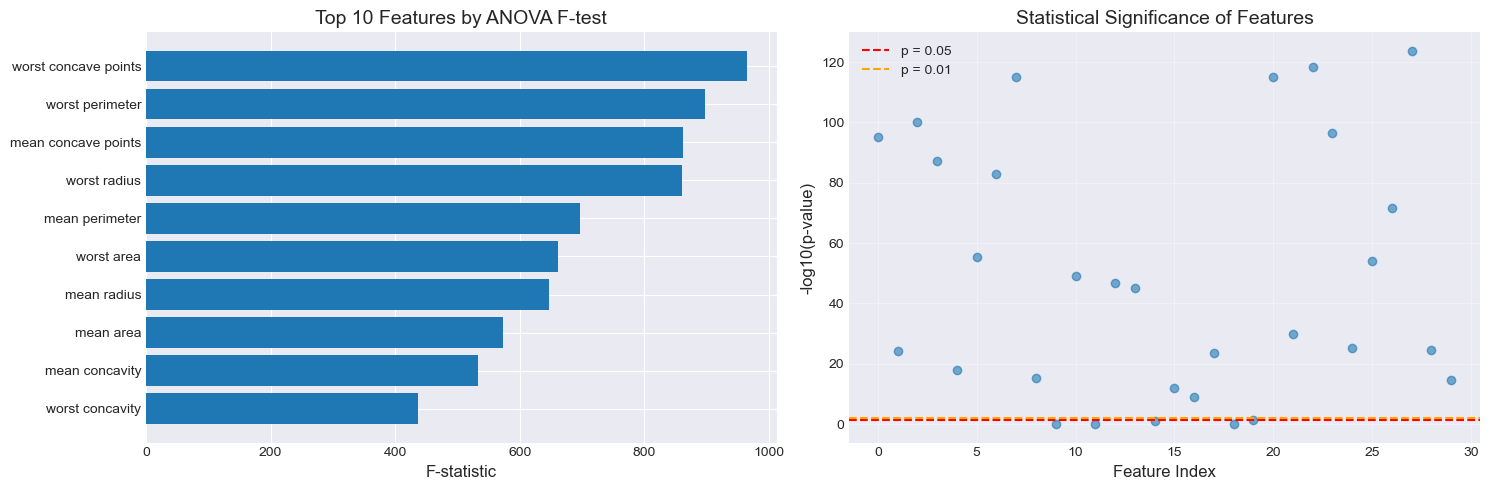

In [9]:
# ANOVA F-test for feature selection
from sklearn.feature_selection import f_classif, SelectKBest

# Compute F-statistics and p-values
f_scores, p_values = f_classif(X_bc, y_bc)

# Create DataFrame for better visualization
f_test_results = pd.DataFrame({
    'Feature': X_bc.columns,
    'F-statistic': f_scores,
    'p-value': p_values,
    '-log10(p)': -np.log10(p_values + 1e-300)  # Add small constant to avoid log(0)
}).sort_values('F-statistic', ascending=False)

print("Top 10 features by ANOVA F-test:")
print(f_test_results.head(10))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# F-statistics
axes[0].barh(range(10), f_test_results['F-statistic'].head(10))
axes[0].set_yticks(range(10))
axes[0].set_yticklabels(f_test_results['Feature'].head(10))
axes[0].set_xlabel('F-statistic', fontsize=12)
axes[0].set_title('Top 10 Features by ANOVA F-test', fontsize=14)
axes[0].invert_yaxis()

# Manhattan plot (volcano plot style)
axes[1].scatter(range(len(f_scores)), -np.log10(p_values + 1e-300), alpha=0.6)
axes[1].axhline(y=-np.log10(0.05), color='r', linestyle='--', label='p = 0.05')
axes[1].axhline(y=-np.log10(0.01), color='orange', linestyle='--', label='p = 0.01')
axes[1].set_xlabel('Feature Index', fontsize=12)
axes[1].set_ylabel('-log10(p-value)', fontsize=12)
axes[1].set_title('Statistical Significance of Features', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Top 10 features by Mutual Information:
                 Feature  F-statistic      MI  Correlation
22       worst perimeter       0.9311  1.0000       0.9865
23            worst area       0.6860  0.9840       0.9241
20          worst radius       0.8926  0.9563       0.9783
7    mean concave points       0.8935  0.9300       0.9785
27  worst concave points       1.0000  0.9246       1.0000
2         mean perimeter       0.7230  0.8527       0.9353
6         mean concavity       0.5535  0.7957       0.8765
0            mean radius       0.6709  0.7678       0.9193
3              mean area       0.5942  0.7630       0.8925
13            area error       0.2526  0.7222       0.6883


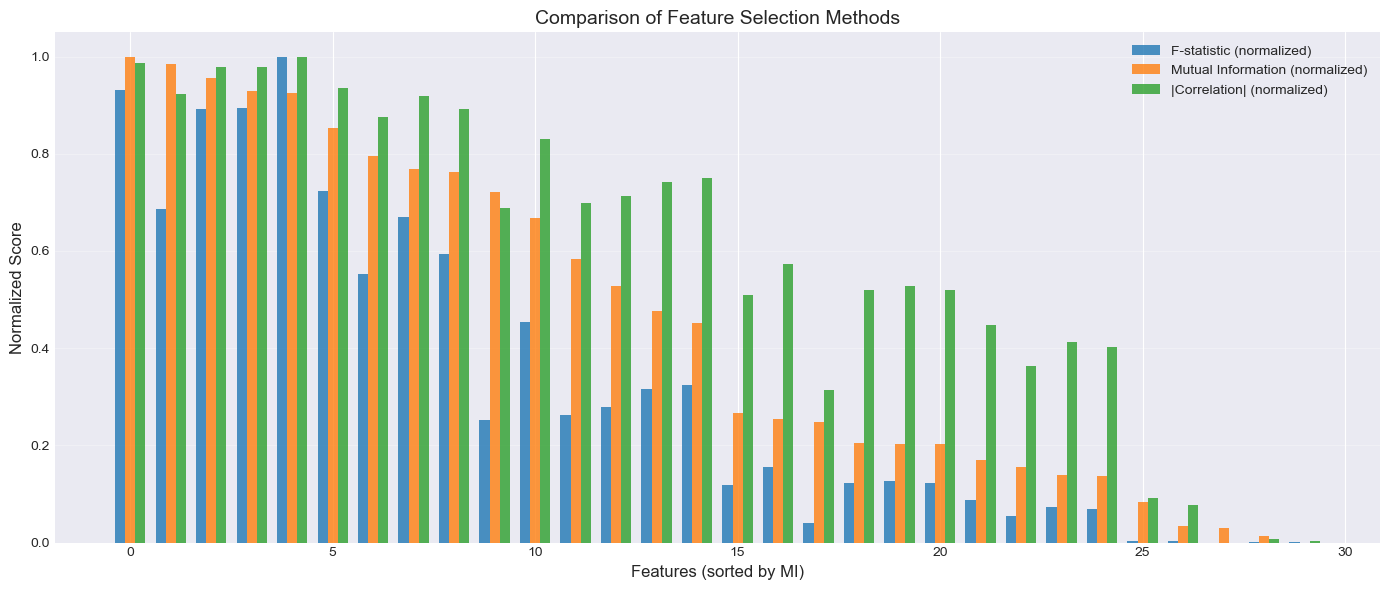

In [10]:
# Mutual Information for feature selection
from sklearn.feature_selection import mutual_info_classif

# Compute mutual information (using 3 nearest neighbors)
mi_scores = mutual_info_classif(X_bc, y_bc, random_state=42)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Feature': X_bc.columns,
    'F-statistic': f_scores,
    'MI': mi_scores,
    'Correlation': [abs(np.corrcoef(X_bc.iloc[:, i], y_bc)[0, 1]) for i in range(X_bc.shape[1])]
})

# Normalize for comparison
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
comparison_df[['F-statistic', 'MI', 'Correlation']] = scaler.fit_transform(
    comparison_df[['F-statistic', 'MI', 'Correlation']]
)

# Sort by MI
comparison_df = comparison_df.sort_values('MI', ascending=False)

print("\nTop 10 features by Mutual Information:")
print(comparison_df.head(10))

# Visualize comparison
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(comparison_df))
width = 0.25

ax.bar(x - width, comparison_df['F-statistic'], width, label='F-statistic (normalized)', alpha=0.8)
ax.bar(x, comparison_df['MI'], width, label='Mutual Information (normalized)', alpha=0.8)
ax.bar(x + width, comparison_df['Correlation'], width, label='|Correlation| (normalized)', alpha=0.8)

ax.set_xlabel('Features (sorted by MI)', fontsize=12)
ax.set_ylabel('Normalized Score', fontsize=12)
ax.set_title('Comparison of Feature Selection Methods', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

---

## 4. Wrapper Methods <a id="wrapper-methods"></a>

### 4.1 Recursive Feature Elimination (RFE)

**Algorithm (RFE):**

**Input:** Training set $\mathcal{D}$, base learner $\mathcal{A}$, target number of features $k$

**Output:** Feature subset $S$ with $|S| = k$

1. Initialize $S = \{1, 2, \ldots, p\}$ (all features)
2. **While** $|S| > k$:
   - Train model $h_S = \mathcal{A}(\mathcal{D}_S)$ using features in $S$
   - Compute feature importance scores: $w_j = \text{Importance}(j, h_S)$ for $j \in S$
   - Remove feature with smallest importance: $S \leftarrow S \setminus \{\arg\min_{j \in S} w_j\}$
3. **Return** $S$

**Feature Importance for Linear Models:**
For linear model $h(\mathbf{x}) = \mathbf{w}^T \mathbf{x} + b$:
$$\text{Importance}(j) = |w_j| \quad \text{or} \quad w_j^2$$

**Feature Importance for Tree-Based Models:**
Gini importance (average decrease in impurity when splitting on feature $j$):
$$\text{Importance}(j) = \sum_{t: \text{splits on } j} p(t) \cdot \Delta i(t)$$
where $p(t)$ is proportion of samples at node $t$ and $\Delta i(t)$ is impurity decrease.

**Computational Complexity:**
- Number of model fits: $O(p - k)$ 
- Total complexity: $O((p-k) \cdot C_{\text{train}})$ where $C_{\text{train}}$ is cost of training base learner

**Advantages:**
- Considers feature interactions
- Can use any base learner
- Produces ranked list of features

**Disadvantages:**
- Computationally expensive
- Greedy (may not find global optimum)
- Sensitive to base learner choice

In [ ]:
# Recursive Feature Elimination with Logistic Regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Create base estimator
log_reg = LogisticRegression(max_iter=10000, random_state=42)

# RFE to select top 10 features
rfe = RFE(estimator=log_reg, n_features_to_select=10, step=1, verbose=1)
rfe.fit(X_bc, y_bc)

# Get selected features
selected_features = X_bc.columns[rfe.support_]
feature_ranking = pd.DataFrame({
    'Feature': X_bc.columns,
    'Ranking': rfe.ranking_,
    'Selected': rfe.support_
}).sort_values('Ranking')

print("\nRFE Feature Ranking:")
print(feature_ranking.head(15))
print(f"\nSelected features ({len(selected_features)}):")
print(list(selected_features))

In [ ]:
# Visualize RFE ranking
plt.figure(figsize=(12, 8))
colors = ['green' if s else 'red' for s in rfe.support_]
plt.barh(range(len(feature_ranking)), feature_ranking['Ranking'], color=colors, alpha=0.6)
plt.yticks(range(len(feature_ranking)), feature_ranking['Feature'])
plt.xlabel('Ranking (1 = best)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('RFE Feature Ranking (Green = Selected)', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# Compare model performance with different numbers of features
from sklearn.model_selection import cross_val_score

# Test different numbers of features
n_features_range = range(1, 31, 2)
cv_scores_mean = []
cv_scores_std = []

for n_features in n_features_range:
    rfe_temp = RFE(estimator=log_reg, n_features_to_select=n_features, step=1)
    rfe_temp.fit(X_bc, y_bc)
    X_selected = X_bc.iloc[:, rfe_temp.support_]
    
    scores = cross_val_score(log_reg, X_selected, y_bc, cv=5, scoring='accuracy')
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())

cv_scores_mean = np.array(cv_scores_mean)
cv_scores_std = np.array(cv_scores_std)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(n_features_range, cv_scores_mean, 'b-o', linewidth=2, markersize=8, label='Mean CV Score')
plt.fill_between(n_features_range, 
                 cv_scores_mean - cv_scores_std, 
                 cv_scores_mean + cv_scores_std, 
                 alpha=0.2, color='blue', label='±1 std')
plt.xlabel('Number of Features', fontsize=12)
plt.ylabel('Cross-Validation Accuracy', fontsize=12)
plt.title('Model Performance vs Number of Features (RFE)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

# Mark optimal point
optimal_idx = np.argmax(cv_scores_mean)
optimal_n_features = list(n_features_range)[optimal_idx]
plt.axvline(x=optimal_n_features, color='red', linestyle='--', 
            label=f'Optimal: {optimal_n_features} features')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nOptimal number of features: {optimal_n_features}")
print(f"Best CV accuracy: {cv_scores_mean[optimal_idx]:.4f} ± {cv_scores_std[optimal_idx]:.4f}")

### 4.2 Forward and Backward Selection

**Forward Selection Algorithm:**

1. Initialize $S = \emptyset$
2. **While** $|S| < k$:
   - For each feature $j \notin S$:
     - Train model on $S \cup \{j\}$
     - Compute score $\text{CV-Score}(S \cup \{j\})$
   - Add best feature: $S \leftarrow S \cup \{\arg\max_j \text{CV-Score}(S \cup \{j\})\}$
3. **Return** $S$

**Backward Elimination:**
- Start with all features
- Iteratively remove worst feature until $k$ remain

**Bidirectional Selection (Stepwise):**
- Combine forward and backward steps
- At each iteration, can add or remove a feature

**Complexity Comparison:**
- Forward: $O(k \cdot p \cdot C_{\text{train}})$
- Backward: $O((p-k) \cdot p \cdot C_{\text{train}})$
- RFE: $O((p-k) \cdot C_{\text{train}})$

---

## 5. Embedded Methods <a id="embedded-methods"></a>

### 5.1 $L_1$ Regularization (Lasso)

**Optimization Problem:**
$$\min_{\mathbf{w}, b} \left[ \frac{1}{2n} \sum_{i=1}^n (y_i - \mathbf{w}^T \mathbf{x}_i - b)^2 + \lambda \|\mathbf{w}\|_1 \right]$$

where $\|\mathbf{w}\|_1 = \sum_{j=1}^p |w_j|$ is the $L_1$ norm.

**Equivalent Constrained Form:**
$$\min_{\mathbf{w}, b} \frac{1}{2n} \sum_{i=1}^n (y_i - \mathbf{w}^T \mathbf{x}_i - b)^2 \quad \text{subject to} \quad \|\mathbf{w}\|_1 \leq t$$

**Why $L_1$ Induces Sparsity:**

Consider the geometric interpretation:
- Level sets of $\|\mathbf{w}\|_1 = t$ form a diamond (cross-polytope) in $\mathbb{R}^p$
- Level sets of loss function are typically ellipsoids
- Diamond has "corners" on coordinate axes
- Solution likely to occur at a corner → sparse solution

**Theorem (Sparsity of Lasso):**
Let $\hat{\mathbf{w}}(\lambda)$ be the Lasso solution. Then:
1. $\|\hat{\mathbf{w}}(\lambda)\|_0 \leq \min\{n, p\}$ (number of nonzero coefficients bounded)
2. As $\lambda \to \infty$: $\hat{\mathbf{w}}(\lambda) \to \mathbf{0}$
3. As $\lambda \to 0$: $\hat{\mathbf{w}}(\lambda) \to \hat{\mathbf{w}}_{\text{OLS}}$ (ordinary least squares)

**Subgradient Condition:**
At optimum, for each $j$:
$$-\frac{1}{n} \sum_{i=1}^n (y_i - \mathbf{w}^T \mathbf{x}_i) x_{ij} + \lambda \cdot \text{sign}(w_j) = 0 \quad \text{if } w_j \neq 0$$

This shows that $w_j = 0$ when correlation with residual is below threshold $\lambda$.

**Soft Thresholding Operator:**
The solution can be written using:
$$S_{\lambda}(z) = \text{sign}(z) \cdot \max\{|z| - \lambda, 0\}$$

### 5.2 $L_2$ Regularization (Ridge)

**Optimization Problem:**
$$\min_{\mathbf{w}, b} \left[ \frac{1}{2n} \sum_{i=1}^n (y_i - \mathbf{w}^T \mathbf{x}_i - b)^2 + \lambda \|\mathbf{w}\|_2^2 \right]$$

**Closed-Form Solution:**
$$\hat{\mathbf{w}}_{\text{ridge}} = (\mathbf{X}^T \mathbf{X} + \lambda n \mathbf{I})^{-1} \mathbf{X}^T \mathbf{y}$$

**Properties:**
- Does NOT produce sparse solutions (all coefficients typically non-zero)
- Shrinks coefficients smoothly
- Geometrically: constraint region is sphere (no corners)
- Better for prediction when many features are relevant

### 5.3 Elastic Net

**Combines $L_1$ and $L_2$:**
$$\min_{\mathbf{w}, b} \left[ \frac{1}{2n} \sum_{i=1}^n (y_i - \mathbf{w}^T \mathbf{x}_i - b)^2 + \lambda \left( \alpha \|\mathbf{w}\|_1 + \frac{1-\alpha}{2} \|\mathbf{w}\|_2^2 \right) \right]$$

where $\alpha \in [0, 1]$ controls the mix:
- $\alpha = 1$: Pure Lasso
- $\alpha = 0$: Pure Ridge  
- $0 < \alpha < 1$: Elastic Net

**Advantages:**
- Sparsity from $L_1$
- Grouping effect from $L_2$ (correlated features get similar coefficients)
- More stable than Lasso when $p > n$

In [ ]:
# Comparison of Lasso, Ridge, and Elastic Net
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler

# Standardize features (important for regularization)
scaler = StandardScaler()
X_bc_scaled = scaler.fit_transform(X_bc)

# Define regularization strengths
alphas = np.logspace(-3, 1, 50)

# Storage for coefficients
lasso_coefs = []
ridge_coefs = []
enet_coefs = []

# Fit models for different alphas
for alpha in alphas:
    # Lasso
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_bc_scaled, y_bc)
    lasso_coefs.append(lasso.coef_)
    
    # Ridge
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_bc_scaled, y_bc)
    ridge_coefs.append(ridge.coef_)
    
    # Elastic Net (alpha=0.5 mix)
    enet = ElasticNet(alpha=alpha, l1_ratio=0.5, max_iter=10000)
    enet.fit(X_bc_scaled, y_bc)
    enet_coefs.append(enet.coef_)

lasso_coefs = np.array(lasso_coefs)
ridge_coefs = np.array(ridge_coefs)
enet_coefs = np.array(enet_coefs)

In [ ]:
# Visualize regularization paths
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Lasso path
for i in range(lasso_coefs.shape[1]):
    axes[0].plot(np.log10(alphas), lasso_coefs[:, i], alpha=0.6)
axes[0].set_xlabel('log10(α)', fontsize=12)
axes[0].set_ylabel('Coefficient Value', fontsize=12)
axes[0].set_title('Lasso Regularization Path', fontsize=14)
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[0].grid(True, alpha=0.3)

# Ridge path
for i in range(ridge_coefs.shape[1]):
    axes[1].plot(np.log10(alphas), ridge_coefs[:, i], alpha=0.6)
axes[1].set_xlabel('log10(α)', fontsize=12)
axes[1].set_ylabel('Coefficient Value', fontsize=12)
axes[1].set_title('Ridge Regularization Path', fontsize=14)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].grid(True, alpha=0.3)

# Elastic Net path
for i in range(enet_coefs.shape[1]):
    axes[2].plot(np.log10(alphas), enet_coefs[:, i], alpha=0.6)
axes[2].set_xlabel('log10(α)', fontsize=12)
axes[2].set_ylabel('Coefficient Value', fontsize=12)
axes[2].set_title('Elastic Net Regularization Path (l1_ratio=0.5)', fontsize=14)
axes[2].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Note: Lasso coefficients go exactly to zero (sparsity)")
print("Ridge coefficients shrink but remain non-zero")
print("Elastic Net shows intermediate behavior")

In [ ]:
# Compare sparsity levels
lasso_sparsity = np.sum(np.abs(lasso_coefs) < 1e-5, axis=1)
ridge_sparsity = np.sum(np.abs(ridge_coefs) < 1e-5, axis=1)
enet_sparsity = np.sum(np.abs(enet_coefs) < 1e-5, axis=1)

plt.figure(figsize=(12, 6))
plt.plot(np.log10(alphas), lasso_sparsity, 'r-o', label='Lasso', linewidth=2, markersize=4)
plt.plot(np.log10(alphas), ridge_sparsity, 'b-s', label='Ridge', linewidth=2, markersize=4)
plt.plot(np.log10(alphas), enet_sparsity, 'g-^', label='Elastic Net', linewidth=2, markersize=4)
plt.xlabel('log10(α)', fontsize=12)
plt.ylabel('Number of Zero Coefficients', fontsize=12)
plt.title('Sparsity Comparison: Lasso vs Ridge vs Elastic Net', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Cross-validation to select optimal alpha for Lasso
from sklearn.linear_model import LassoCV

# Use LassoCV with cross-validation
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=10000, random_state=42)
lasso_cv.fit(X_bc_scaled, y_bc)

print(f"Optimal alpha: {lasso_cv.alpha_:.4f}")
print(f"\nNumber of selected features: {np.sum(np.abs(lasso_cv.coef_) > 1e-5)}")

# Get selected features
selected_mask = np.abs(lasso_cv.coef_) > 1e-5
selected_features_lasso = X_bc.columns[selected_mask]
selected_coefs = lasso_cv.coef_[selected_mask]

# Create DataFrame
lasso_features_df = pd.DataFrame({
    'Feature': selected_features_lasso,
    'Coefficient': selected_coefs,
    'Abs_Coefficient': np.abs(selected_coefs)
}).sort_values('Abs_Coefficient', ascending=False)

print("\nSelected features and their coefficients:")
print(lasso_features_df)

# Visualize
plt.figure(figsize=(12, 6))
colors = ['green' if c > 0 else 'red' for c in lasso_features_df['Coefficient']]
plt.barh(range(len(lasso_features_df)), lasso_features_df['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(lasso_features_df)), lasso_features_df['Feature'])
plt.xlabel('Lasso Coefficient', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title(f'Lasso-Selected Features (α = {lasso_cv.alpha_:.4f})', fontsize=14)
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 5.4 Tree-Based Feature Importance

#### Gini Importance (Mean Decrease Impurity)

**Gini Impurity:**
For a node with class proportions $p_1, \ldots, p_K$:
$$I_G = \sum_{k=1}^K p_k(1 - p_k) = 1 - \sum_{k=1}^K p_k^2$$

**Feature Importance:**
$$\text{Importance}(j) = \sum_{t \in \text{nodes using } j} p(t) \left[ I(t) - p_{\text{left}} I(t_{\text{left}}) - p_{\text{right}} I(t_{\text{right}}) \right]$$

where:
- $p(t)$ = proportion of samples reaching node $t$
- $I(t)$ = impurity at node $t$
- $p_{\text{left}}, p_{\text{right}}$ = proportion going left/right

**For Random Forests:**
Average importance across all trees:
$$\text{Importance}(j) = \frac{1}{T} \sum_{t=1}^T \text{Importance}_t(j)$$

#### Permutation Importance

**Algorithm:**
1. Train model on full dataset → get baseline score $S_0$
2. For each feature $j$:
   - Randomly permute feature $j$ in test set
   - Compute score $S_j$ with permuted feature
   - Importance = $S_0 - S_j$ (decrease in performance)

**Advantages:**
- Model-agnostic
- Reflects true impact on predictions
- Can use any performance metric

**Disadvantages:**
- Computationally expensive
- Can be biased if features are correlated

In [ ]:
# Random Forest Feature Importance
from sklearn.ensemble import RandomForestClassifier

# Train random forest
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_bc, y_bc)

# Get feature importances
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': X_bc.columns,
    'Importance': importances,
    'Std': std
}).sort_values('Importance', ascending=False)

print("Top 15 features by Random Forest importance:")
print(importance_df.head(15))

# Visualize
plt.figure(figsize=(12, 8))
plt.barh(range(len(importance_df)), importance_df['Importance'], 
         xerr=importance_df['Std'], alpha=0.7, capsize=3)
plt.yticks(range(len(importance_df)), importance_df['Feature'])
plt.xlabel('Mean Decrease in Impurity', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Random Forest Feature Importance (with std)', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# Permutation Importance
from sklearn.inspection import permutation_importance

# Split data for unbiased permutation importance
X_train, X_test, y_train, y_test = train_test_split(X_bc, y_bc, test_size=0.3, random_state=42)

# Train model
rf.fit(X_train, y_train)

# Compute permutation importance
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, 
                                          random_state=42, n_jobs=-1)

# Create DataFrame
perm_importance_df = pd.DataFrame({
    'Feature': X_bc.columns,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False)

print("\nTop 15 features by Permutation Importance:")
print(perm_importance_df.head(15))

# Compare Gini vs Permutation importance
comparison = pd.merge(importance_df[['Feature', 'Importance']], 
                     perm_importance_df[['Feature', 'Importance']], 
                     on='Feature', suffixes=('_Gini', '_Perm'))

plt.figure(figsize=(10, 10))
plt.scatter(comparison['Importance_Gini'], comparison['Importance_Perm'], alpha=0.6, s=100)
for idx, row in comparison.iterrows():
    if row['Importance_Gini'] > 0.02 or row['Importance_Perm'] > 0.01:
        plt.annotate(row['Feature'], (row['Importance_Gini'], row['Importance_Perm']), 
                    fontsize=8, alpha=0.7)
plt.xlabel('Gini Importance', fontsize=12)
plt.ylabel('Permutation Importance', fontsize=12)
plt.title('Gini vs Permutation Feature Importance', fontsize=14)
plt.plot([0, max(comparison['Importance_Gini'])], [0, max(comparison['Importance_Gini'])], 
         'r--', label='y=x', alpha=0.5)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

## 6. Dimensionality Reduction: Principal Component Analysis <a id="dimensionality-reduction"></a>

### 6.1 Mathematical Formulation

**Goal:** Find orthogonal directions of maximum variance in the data.

**Problem Statement:**
Given data matrix $\mathbf{X} \in \mathbb{R}^{n \times p}$ (centered: $\sum_i \mathbf{x}_i = \mathbf{0}$), find orthonormal vectors $\mathbf{v}_1, \ldots, \mathbf{v}_k$ that maximize projected variance:

$$\max_{\mathbf{v}_1, \ldots, \mathbf{v}_k} \sum_{j=1}^k \mathbf{v}_j^T \mathbf{\Sigma} \mathbf{v}_j \quad \text{subject to} \quad \mathbf{v}_i^T \mathbf{v}_j = \delta_{ij}$$

where $\mathbf{\Sigma} = \frac{1}{n} \mathbf{X}^T \mathbf{X}$ is the sample covariance matrix.

### 6.2 Solution via Eigendecomposition

**Theorem (PCA Solution):**
The principal components are eigenvectors of the covariance matrix $\mathbf{\Sigma}$:
$$\mathbf{\Sigma} \mathbf{v}_j = \lambda_j \mathbf{v}_j$$

where $\lambda_1 \geq \lambda_2 \geq \cdots \geq \lambda_p \geq 0$ are eigenvalues (sorted in decreasing order).

**Variance Explained:**
- $j$-th principal component explains variance: $\lambda_j$
- Total variance: $\sum_{j=1}^p \lambda_j = \text{tr}(\mathbf{\Sigma})$
- Proportion of variance explained by first $k$ components:
  $$\frac{\sum_{j=1}^k \lambda_j}{\sum_{j=1}^p \lambda_j}$$

### 6.3 Projection and Reconstruction

**Projection:** Transform data to $k$-dimensional space:
$$\mathbf{Z} = \mathbf{X} \mathbf{V}_k \in \mathbb{R}^{n \times k}$$
where $\mathbf{V}_k = [\mathbf{v}_1 | \cdots | \mathbf{v}_k]$

**Reconstruction:**
$$\tilde{\mathbf{X}} = \mathbf{Z} \mathbf{V}_k^T = \mathbf{X} \mathbf{V}_k \mathbf{V}_k^T$$

**Reconstruction Error:**
$$\|\mathbf{X} - \tilde{\mathbf{X}}\|_F^2 = \sum_{j=k+1}^p \lambda_j$$

### 6.4 Connection to SVD

**Singular Value Decomposition:**
$$\mathbf{X} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T$$

where:
- $\mathbf{U} \in \mathbb{R}^{n \times p}$: left singular vectors
- $\mathbf{\Sigma} \in \mathbb{R}^{p \times p}$: diagonal matrix of singular values $\sigma_1 \geq \cdots \geq \sigma_p$
- $\mathbf{V} \in \mathbb{R}^{p \times p}$: right singular vectors (= PCA directions)

**Relationship:**
- Principal components: columns of $\mathbf{V}$
- Eigenvalues: $\lambda_j = \sigma_j^2 / n$
- Principal component scores: $\mathbf{Z} = \mathbf{U} \mathbf{\Sigma}$

### 6.5 Probabilistic Interpretation (PPCA)

**Latent Variable Model:**
$$\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}_k), \quad \mathbf{x} | \mathbf{z} \sim \mathcal{N}(\mathbf{W}\mathbf{z}, \sigma^2 \mathbf{I}_p)$$

**Marginal Distribution:**
$$\mathbf{x} \sim \mathcal{N}(\mathbf{0}, \mathbf{W}\mathbf{W}^T + \sigma^2 \mathbf{I})$$

As $\sigma^2 \to 0$, the MLE for $\mathbf{W}$ converges to PCA solution.

In [ ]:
# PCA on Breast Cancer Dataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize (essential for PCA!)
scaler = StandardScaler()
X_bc_scaled = scaler.fit_transform(X_bc)

# Fit PCA
pca = PCA()
pca.fit(X_bc_scaled)

# Eigenvalues (variances)
eigenvalues = pca.explained_variance_
explained_var_ratio = pca.explained_variance_ratio_
cumulative_var_ratio = np.cumsum(explained_var_ratio)

print("Variance explained by each component:")
for i in range(min(10, len(eigenvalues))):
    print(f"PC{i+1}: {explained_var_ratio[i]:.4f} ({cumulative_var_ratio[i]:.4f} cumulative)")

print(f"\nNumber of components for 95% variance: {np.argmax(cumulative_var_ratio >= 0.95) + 1}")
print(f"Number of components for 99% variance: {np.argmax(cumulative_var_ratio >= 0.99) + 1}")

In [ ]:
# Scree plot and cumulative variance
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scree plot
axes[0].plot(range(1, len(eigenvalues)+1), eigenvalues, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Eigenvalue (Variance)', fontsize=12)
axes[0].set_title('Scree Plot', fontsize=14)
axes[0].grid(True, alpha=0.3)

# Cumulative variance explained
axes[1].plot(range(1, len(cumulative_var_ratio)+1), cumulative_var_ratio, 'ro-', 
             linewidth=2, markersize=8)
axes[1].axhline(y=0.95, color='green', linestyle='--', label='95% variance')
axes[1].axhline(y=0.99, color='orange', linestyle='--', label='99% variance')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Variance Explained', fontsize=12)
axes[1].set_title('Cumulative Variance Explained', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

In [ ]:
# Project onto first 2 PCs and visualize
pca_2d = PCA(n_components=2)
X_pca = pca_2d.fit_transform(X_bc_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_bc, cmap='coolwarm', 
                     alpha=0.6, edgecolors='black', linewidth=0.5, s=50)
plt.xlabel(f'PC1 ({explained_var_ratio[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({explained_var_ratio[1]:.1%} variance)', fontsize=12)
plt.title('PCA Projection: First Two Principal Components', fontsize=14)
plt.colorbar(scatter, label='Class (0=malignant, 1=benign)')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
plt.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

print(f"\nLinear separability in 2D: Classes are {'well' if explained_var_ratio[0] > 0.4 else 'moderately'} separated")

In [ ]:
# Feature loadings (eigenvectors)
loadings = pca_2d.components_.T * np.sqrt(pca_2d.explained_variance_)

loading_df = pd.DataFrame(
    loadings,
    columns=['PC1', 'PC2'],
    index=X_bc.columns
)

# Biplot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot data points
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y_bc, cmap='coolwarm', alpha=0.3, s=30)

# Plot loadings as arrows
scale_factor = 3
for i, feature in enumerate(X_bc.columns):
    ax.arrow(0, 0, loadings[i, 0]*scale_factor, loadings[i, 1]*scale_factor,
             head_width=0.2, head_length=0.2, fc='red', ec='red', alpha=0.6)
    ax.text(loadings[i, 0]*scale_factor*1.15, loadings[i, 1]*scale_factor*1.15, 
            feature, fontsize=8, ha='center', va='center')

ax.set_xlabel(f'PC1 ({explained_var_ratio[0]:.1%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({explained_var_ratio[1]:.1%} variance)', fontsize=12)
ax.set_title('PCA Biplot: Features and Observations', fontsize=14)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax.axvline(x=0, color='k', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

print("\nInterpretation: Arrow direction shows feature contribution to PCs")
print("Arrow length shows strength of contribution")

In [ ]:
# Compare classification performance: Original vs PCA features
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

n_components_range = range(1, 31)
pca_scores = []

for n_comp in n_components_range:
    pca_temp = PCA(n_components=n_comp)
    X_pca_temp = pca_temp.fit_transform(X_bc_scaled)
    
    lr = LogisticRegression(max_iter=10000, random_state=42)
    scores = cross_val_score(lr, X_pca_temp, y_bc, cv=5, scoring='accuracy')
    pca_scores.append(scores.mean())

# Baseline with all features
baseline_scores = cross_val_score(lr, X_bc_scaled, y_bc, cv=5, scoring='accuracy')
baseline_mean = baseline_scores.mean()

plt.figure(figsize=(12, 6))
plt.plot(n_components_range, pca_scores, 'b-o', linewidth=2, markersize=6, 
         label='PCA + Logistic Regression')
plt.axhline(y=baseline_mean, color='red', linestyle='--', linewidth=2, 
            label=f'Baseline (all features): {baseline_mean:.4f}')
plt.xlabel('Number of Principal Components', fontsize=12)
plt.ylabel('Cross-Validation Accuracy', fontsize=12)
plt.title('Classification Performance vs Number of PCA Components', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

optimal_n_comp = n_components_range[np.argmax(pca_scores)]
print(f"\nOptimal number of components: {optimal_n_comp}")
print(f"Best PCA accuracy: {max(pca_scores):.4f}")
print(f"Baseline accuracy: {baseline_mean:.4f}")
print(f"Difference: {max(pca_scores) - baseline_mean:.4f}")

---

## 7. Advanced Topics <a id="advanced-topics"></a>

### 7.1 Bias-Variance Tradeoff in Feature Selection

**Bias-Variance Decomposition:**

For squared loss, the expected prediction error decomposes as:
$$\mathbb{E}[(y - \hat{f}(\mathbf{x}))^2] = \text{Bias}^2(\hat{f}(\mathbf{x})) + \text{Var}(\hat{f}(\mathbf{x})) + \sigma^2$$

where:
- $\text{Bias}(\hat{f}(\mathbf{x})) = \mathbb{E}[\hat{f}(\mathbf{x})] - f(\mathbf{x})$
- $\text{Var}(\hat{f}(\mathbf{x})) = \mathbb{E}[(\hat{f}(\mathbf{x}) - \mathbb{E}[\hat{f}(\mathbf{x})])^2]$
- $\sigma^2$ = irreducible error

**Impact of Feature Selection:**

Removing features:
- **Increases bias:** Model becomes less flexible, may underfit
- **Decreases variance:** Fewer parameters to estimate, more stable
- **Net effect:** Depends on whether removed features are truly relevant

**Theorem (Feature Selection Bias):**
If feature selection and model fitting use the same data, performance estimates are optimistically biased:
$$\mathbb{E}[\text{CV-Error}_{\text{same data}}] \leq \mathbb{E}[\text{True-Error}]$$

**Solution:** Use nested cross-validation or separate validation set.

### 7.2 Stability of Feature Selection

**Definition (Stability):**
A feature selection method is stable if small changes in data lead to small changes in selected features.

**Jaccard Similarity:**
$$J(S_1, S_2) = \frac{|S_1 \cap S_2|}{|S_1 \cup S_2|}$$

**Kuncheva Index:**
$$K(S_1, S_2) = \frac{|S_1 \cap S_2| - \frac{k^2}{p}}{k - \frac{k^2}{p}}$$

where $k = |S_1| = |S_2|$ and $p$ is total number of features.

**Empirical Stability:**
1. Create bootstrap samples $\mathcal{D}_1, \ldots, \mathcal{D}_B$
2. Apply feature selection to each: $S_1, \ldots, S_B$
3. Compute pairwise similarities: $\text{Stability} = \frac{2}{B(B-1)} \sum_{i<j} J(S_i, S_j)$

### 7.3 Multiple Testing Correction

When testing $p$ features, false positives accumulate.

**Family-Wise Error Rate (FWER):**
$$\text{FWER} = P(\text{at least one false positive})$$

**Bonferroni Correction:**
Test each hypothesis at level $\alpha/p$ to control FWER at $\alpha$.

**False Discovery Rate (FDR):**
$$\text{FDR} = \mathbb{E}\left[\frac{\text{# false positives}}{\text{# total positives}}\right]$$

**Benjamini-Hochberg Procedure:**
1. Order p-values: $p_{(1)} \leq p_{(2)} \leq \cdots \leq p_{(p)}$
2. Find largest $k$ such that $p_{(k)} \leq \frac{k}{p} \alpha$
3. Reject hypotheses $1, \ldots, k$

This controls FDR at level $\alpha$.

---

## 8. Practical Guidelines and Comparative Analysis <a id="guidelines"></a>

### 8.1 Method Selection Guide

| **Scenario** | **Recommended Method** | **Rationale** |
|-------------|----------------------|-------------|
| High-dimensional, $p >> n$ | Lasso, Elastic Net | Handles many features, produces sparse solutions |
| Correlated features | Elastic Net, PCA | Handles multicollinearity well |
| Interpretability crucial | Lasso, Tree importance | Clear feature ranking |
| Nonlinear relationships | Tree-based methods, MI | Captures complex patterns |
| Fast screening needed | Variance threshold, correlation | Computationally cheap |
| Small $p$, large $n$ | Wrapper methods (RFE) | Can afford computational cost |
| Mixed feature types | Tree-based methods | Handles categorical and continuous |

### 8.2 Best Practices

1. **Always use cross-validation:**
   - Nested CV for unbiased performance estimates
   - Outer loop: model evaluation
   - Inner loop: feature selection + hyperparameter tuning

2. **Standardize features:**
   - Essential for regularization methods
   - Important for distance-based methods
   - Use StandardScaler or similar

3. **Domain knowledge:**
   - Incorporate expert knowledge when possible
   - Don't blindly trust automated methods
   - Validate selected features scientifically

4. **Multiple methods:**
   - Compare different approaches
   - Look for consensus features
   - Ensemble selection methods

5. **Stability analysis:**
   - Check if selected features are stable
   - Use bootstrap or cross-validation
   - Report confidence in selections

### 8.3 Common Pitfalls

**❌ Selection bias:**
- Performing feature selection on entire dataset before CV
- **Fix:** Include selection in CV loop

**❌ Ignoring correlation:**
- Selecting redundant features
- **Fix:** Check correlation matrix, use Elastic Net

**❌ Wrong null hypothesis:**
- Testing $H_0: \text{no effect}$ when you want $H_1: \text{strong effect}$
- **Fix:** Use effect size, not just p-values

**❌ Data leakage:**
- Using test set information in selection
- **Fix:** Strict train/test separation

**❌ Ignoring feature interactions:**
- Removing features that are important in combination
- **Fix:** Use methods that consider interactions (trees, wrappers)

---

## 9. Complete End-to-End Example <a id="examples"></a>

### Comprehensive Feature Selection Pipeline

We'll build a complete pipeline that:
1. Applies multiple feature selection methods
2. Compares their performance
3. Uses proper cross-validation
4. Reports stable features

In [ ]:
# Complete feature selection comparison
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Prepare data
X_train, X_test, y_train, y_test = train_test_split(
    X_bc, y_bc, test_size=0.2, stratify=y_bc, random_state=42
)

# Define different feature selection strategies
feature_selectors = {
    'All Features': None,
    'Variance (0.1)': VarianceThreshold(threshold=0.1),
    'Top 10 (F-test)': SelectKBest(f_classif, k=10),
    'Top 10 (MI)': SelectKBest(mutual_info_classif, k=10),
    'Lasso': SelectFromModel(Lasso(alpha=0.01, max_iter=10000)),
    'RF Importance': SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42)),
    'RFE (10 feat)': RFE(LogisticRegression(max_iter=10000), n_features_to_select=10),
    'PCA (95%)': PCA(n_components=0.95)
}

# Test each method
results = {}
selected_features_dict = {}

for name, selector in feature_selectors.items():
    print(f"\nTesting {name}...")
    
    if selector is None:
        # No feature selection
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(max_iter=10000, random_state=42))
        ])
    else:
        # With feature selection
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('selector', selector),
            ('classifier', LogisticRegression(max_iter=10000, random_state=42))
        ])
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')
    
    results[name] = {
        'mean_cv_score': scores.mean(),
        'std_cv_score': scores.std(),
        'scores': scores
    }
    
    # Fit to get selected features
    pipeline.fit(X_train, y_train)
    
    if selector is not None and hasattr(selector, 'get_support'):
        selected_features_dict[name] = X_bc.columns[selector.get_support()].tolist()
    elif isinstance(selector, PCA):
        selected_features_dict[name] = f"{selector.n_components_} components"
    else:
        selected_features_dict[name] = 'All features'
    
    print(f"  Mean CV Score: {scores.mean():.4f} ± {scores.std():.4f}")
    if isinstance(selected_features_dict[name], list):
        print(f"  Features selected: {len(selected_features_dict[name])}")

In [ ]:
# Visualize comparison
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('mean_cv_score', ascending=False)

print("\n" + "="*80)
print("FEATURE SELECTION COMPARISON RESULTS")
print("="*80)
print(results_df[['mean_cv_score', 'std_cv_score']])

# Bar plot
fig, ax = plt.subplots(figsize=(12, 6))
x_pos = np.arange(len(results_df))
ax.bar(x_pos, results_df['mean_cv_score'], 
       yerr=results_df['std_cv_score'],
       alpha=0.7, capsize=5, color='steelblue', edgecolor='black')
ax.set_xticks(x_pos)
ax.set_xticklabels(results_df.index, rotation=45, ha='right')
ax.set_ylabel('Cross-Validation Accuracy', fontsize=12)
ax.set_title('Feature Selection Methods Comparison', fontsize=14, fontweight='bold')
ax.set_ylim([0.9, 1.0])
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (idx, row) in enumerate(results_df.iterrows()):
    ax.text(i, row['mean_cv_score'] + 0.003, f"{row['mean_cv_score']:.4f}", 
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# Feature consensus analysis
# Find features selected by multiple methods

from collections import Counter

# Collect all selected features
all_selected = []
for method, features in selected_features_dict.items():
    if isinstance(features, list):
        all_selected.extend(features)

# Count occurrences
feature_counts = Counter(all_selected)
consensus_df = pd.DataFrame([
    {'Feature': feat, 'Count': count} 
    for feat, count in feature_counts.items()
]).sort_values('Count', ascending=False)

print("\n" + "="*80)
print("FEATURE CONSENSUS ANALYSIS")
print("="*80)
print("\nFeatures selected by multiple methods:")
print(consensus_df.head(20))

# Visualize
plt.figure(figsize=(14, 8))
plt.barh(range(len(consensus_df)), consensus_df['Count'], alpha=0.7)
plt.yticks(range(len(consensus_df)), consensus_df['Feature'])
plt.xlabel('Number of Methods Selecting This Feature', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Selection Consensus Across Methods', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# High consensus features
max_methods = consensus_df['Count'].max()
high_consensus = consensus_df[consensus_df['Count'] >= max_methods - 1]['Feature'].tolist()
print(f"\nHigh-consensus features (selected by {max_methods-1}+ methods):")
print(high_consensus)

In [ ]:
# Final model with consensus features
print("\n" + "="*80)
print("FINAL MODEL WITH CONSENSUS FEATURES")
print("="*80)

# Use high-consensus features
X_train_consensus = X_train[high_consensus]
X_test_consensus = X_test[high_consensus]

# Train final model
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=10000, random_state=42))
])

final_pipeline.fit(X_train_consensus, y_train)
y_pred = final_pipeline.predict(X_test_consensus)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix

print(f"\nNumber of features used: {len(high_consensus)}")
print(f"Features: {high_consensus}")
print(f"\nTest Set Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Malignant', 'Benign']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title('Confusion Matrix: Consensus Feature Model', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

## Summary and Key Takeaways

### Mathematical Insights

1. **Filter methods** use statistical properties (variance, correlation, MI) - fast but ignore model performance

2. **Wrapper methods** use the model itself (RFE, forward/backward) - slow but consider interactions

3. **Embedded methods** integrate selection into training (Lasso, trees) - good balance of speed and performance

4. **Regularization** provides implicit feature selection:
   - $L_1$ (Lasso): Sparse solutions via soft thresholding
   - $L_2$ (Ridge): Coefficient shrinkage without sparsity
   - Elastic Net: Best of both worlds

5. **PCA** finds orthogonal directions of maximum variance - useful for visualization and handling multicollinearity

### Practical Recommendations

1. **Start simple:** Variance threshold, correlation analysis
2. **Use domain knowledge:** Don't blindly trust algorithms
3. **Cross-validate properly:** Nested CV to avoid selection bias
4. **Compare methods:** Look for consensus features
5. **Check stability:** Bootstrap or CV-based stability measures
6. **Consider the goal:** 
   - Prediction → any method that works
   - Interpretation → sparse methods (Lasso, trees)
   - Discovery → multiple methods + validation

### For Further Study

- **Stability selection** (Meinshausen & Bühlmann, 2010)
- **Group Lasso** for structured sparsity
- **$L_0$ regularization** and best subset selection
- **Causal feature selection** (not just correlation)
- **Deep learning** feature learning

---

## References

1. Guyon, I., & Elisseeff, A. (2003). An introduction to variable and feature selection. *JMLR*.
2. Hastie, T., Tibshirani, R., & Friedman, J. (2009). *The Elements of Statistical Learning*.
3. Tibshirani, R. (1996). Regression shrinkage and selection via the lasso. *JRSS-B*.
4. Zou, H., & Hastie, T. (2005). Regularization and variable selection via the elastic net. *JRSS-B*.
5. Breiman, L. (2001). Random forests. *Machine Learning*.
6. Meinshausen, N., & Bühlmann, P. (2010). Stability selection. *JRSS-B*.